In [1]:
import os
import pandas as pd
import numpy as np
import tabulate
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mtick
from openpyxl import Workbook

# 讀取檔案所需資料 (function)

In [2]:
def GetTradeData(fileName):
    TradeData = pd.read_excel("./" + fileName, 
                        sheet_name='交易明細',
                        skiprows = range(0, 2),
                        usecols = "E:J")
    TradeData_df = pd.DataFrame(TradeData, columns=['日期','獲利(¤)'])
    TradeData_df['獲利(¤)'].fillna(method='ffill', inplace=True)
    TradeData_df_filterTheClosing = TradeData_df[np.arange(len(TradeData_df)) % 2 == 1]
    return TradeData_df_filterTheClosing

# 合併績效報告

In [3]:
filesInFolder = []
for subdir, dirs, files in os.walk('./'):
    for file in files:
        filesInFolder.append(file)

reports = list(filter(lambda k: '策略回測績效報告' in k, filesInFolder))

df_summary = pd.DataFrame({'日期':datetime(1911, 1, 1),'獲利(¤)':[200100.0]})

for report in reports:
    df_summary = pd.concat([df_summary, GetTradeData(report)], axis=0, sort=True).sort_values(['日期']).reset_index(drop=True)

tradeFee = 50
    
df_summary['獲利(¤)'] = df_summary['獲利(¤)'] - tradeFee*2
df_summary['TotalEquity'] = df_summary['獲利(¤)'].cumsum()

# 歷史損益曲線

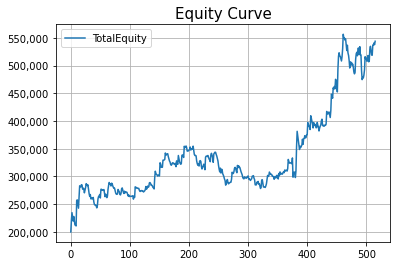

In [4]:
ax = df_summary.plot(y='TotalEquity', grid=True)
ax.yaxis.set_major_formatter(lambda x, p: format(int(x), ','))
plt.title('Equity Curve', fontsize=15)
plt.show()

# 年度損益

Text(0.5, 1.0, 'Annual Profit and Loss')

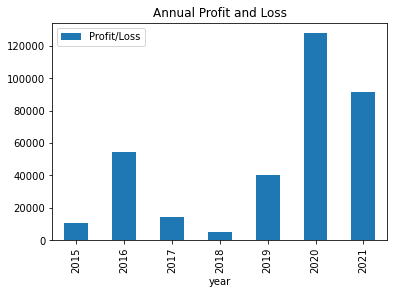

In [5]:
df_summary['year'] = df_summary['日期'].apply(lambda x:x.year)
df_groupby_year = df_summary.groupby(by=['year']).agg('sum')
del df_groupby_year['TotalEquity']
df_groupby_year = df_groupby_year.rename(columns={'獲利(¤)': 'Profit/Loss'}, index={})
df_groupby_year[1:].plot(kind='bar')
plt.title('Annual Profit and Loss')

# DrawDown - Max & Daliy (Percentage)

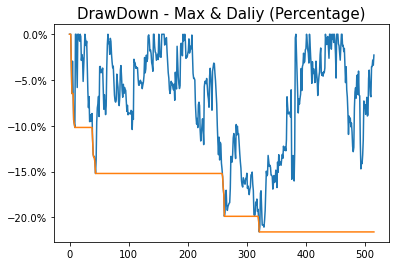

In [6]:
Roll_Max = df_summary['TotalEquity'].rolling(df_summary['日期'].count(), min_periods=1).max()

df_summary['Daily_Drawdown'] = df_summary['TotalEquity']/Roll_Max - 1.0
df_summary['Max_Daily_Drawdown'] = df_summary['Daily_Drawdown'].rolling(df_summary['日期'].count(), min_periods=1).min()
dd = df_summary['Daily_Drawdown'].plot()
dd.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
mdd = df_summary['Max_Daily_Drawdown'].plot()
mdd.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title('DrawDown - Max & Daliy (Percentage)', fontsize=15)
plt.show()

# DrawDown - Max & Daliy (Number)

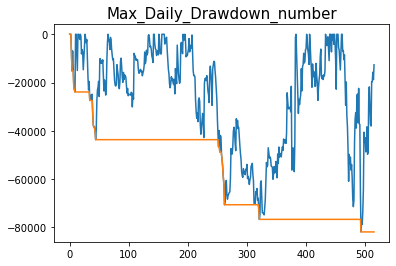

In [7]:
df_summary['Daily_Drawdown_number'] = df_summary['TotalEquity'] - Roll_Max
df_summary['Max_Daily_Drawdown_number'] = df_summary['Daily_Drawdown_number'].rolling(df_summary['日期'].count(), min_periods=1).min()

dd_by_number = df_summary['Daily_Drawdown_number'].plot()
dd.yaxis.set_major_formatter(lambda x, p: format(int(x), ','))
mdd_by_number = df_summary['Max_Daily_Drawdown_number'].plot()
mdd.yaxis.set_major_formatter(lambda x, p: format(int(x), ','))
plt.title('Max_Daily_Drawdown_number', fontsize=15)
plt.show()

# Profit/Loss Scatter (損益散佈圖)

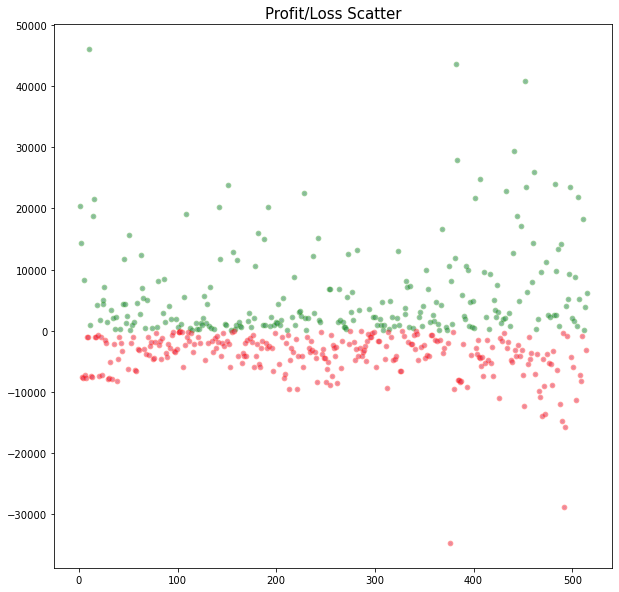

In [8]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1)
profit_df = df_summary.loc[df_summary['獲利(¤)'] > 0][1:]
loss_df = df_summary.loc[df_summary['獲利(¤)'] < 0]

ax.scatter(profit_df.index, profit_df['獲利(¤)'], s=10, alpha=0.4, linewidths=2.5, c='#AAAFFF', edgecolors='green')
ax.scatter(loss_df.index, loss_df['獲利(¤)'], s=10, alpha=0.4, linewidths=2.5, c='#AAAFFF', edgecolors='red')
plt.title('Profit/Loss Scatter', fontsize=15)
plt.show()

# Profit Factor

In [9]:
gross_profit = profit_df['獲利(¤)'].sum()
gross_loss = loss_df['獲利(¤)'].sum()

result_summary = pd.DataFrame({'Profit_Factor':'%.2f' % (gross_profit/gross_loss*-1),'Max_Drawdown':['%.f' % (df_summary['Max_Daily_Drawdown_number'].min())]})
print(result_summary.to_string(index=False))

Profit_Factor Max_Drawdown
         1.31       -81850


In [10]:
%%capture
os.system('jupyter nbconvert --to html PortfolioManager_Beta.ipynb')

In [11]:
FILE = "./PortfolioManager_Beta.html"

with open(FILE, 'r',encoding="utf-8") as html_file:
    content = html_file.read()

content = content.replace(".jp-Cell-inputWrapper,",".jp-Cell-inputWrapper {\ndisplay: none;\n}")  
content = content.replace("Text(0.5, 1.0, &#39;Annual Profit and Loss&#39;)","")
content = content.replace(".jp-OutputPrompt {",".jp-OutputPrompt {\ndisplay: none;\n")
content = content.replace(".jp-OutputArea-output {",".jp-OutputArea-output {\njustify-content: center;display: flex;\n")
    
f = open(FILE, 'w',encoding="utf-8")
f.write(content)
f.close()